In [1]:
%matplotlib inline
import sys
import os
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params, load_params
from dynamic_population_sim import DynamicPopulationSim
from multi_group_simulation_dynamic_population import MultiGroupSimulationDynamicPopulation
import pandas as pd
from datetime import date, timedelta
import dill

from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

from math import sqrt
from analysis_helpers import binomial_exit_function
import gc
gc.collect()
import multiprocessing as mp
mp.cpu_count()

80

In [2]:
from calibrated_student import *
from calibrated_FS import *

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:
def get_calibrated_trajs(ntrajs, test_policy=[2/7, 2/7, 1/7]):
    student_results = sample_student_trajectories(ntrajs, sem_test_policy = test_policy)
    FS_results = sample_FS_trajectories(ntrajs)
    return_list = list()
    for list_dfs, FS_df in zip(student_results, FS_results):
        list_dfs.extend([FS_df])
        return_list.append(list_dfs)
    return return_list

# Figures

### Faculty / Staff Calibration Results
Results generated by Brian, improted and plotted in notebook

In [4]:
# importing results
FS_cal_results = pd.read_csv('FS_results_calib_results.csv')
FS_cal_results['log_score'] = np.log(FS_cal_results['score'])
FS_cal_results.sort_values('score',ascending = True)

,Unnamed: 0,transmission_p,score,log_score
9,9,0.011,104.803082,4.652083
10,10,0.012,161.622004,5.085260
8,8,0.010,191.370854,5.254213
7,7,0.009,328.879418,5.795691
11,11,0.013,381.722357,5.944694
6,6,0.008,489.733972,6.193862
5,5,0.007,760.094091,6.633442
4,4,0.006,974.302601,6.881722
3,3,0.005,1154.799393,7.051682
12,12,0.014,1203.584186,7.093059


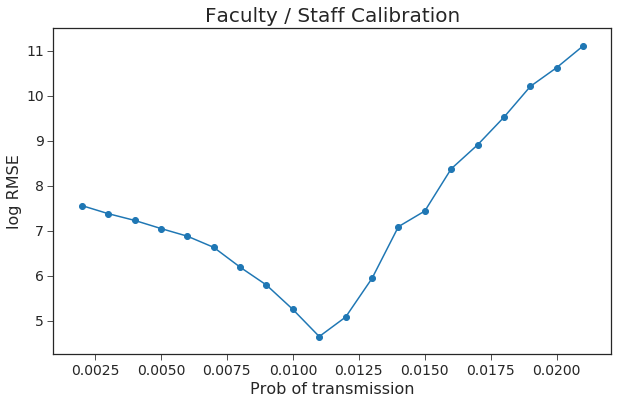

In [5]:
plt.figure(figsize=(10,6))
plt.plot('transmission_p', 'log_score', data=FS_cal_results)
plt.scatter('transmission_p', 'log_score', data=FS_cal_results)

plt.title('Faculty / Staff Calibration')
plt.ylabel('log RMSE')
plt.xlabel('Prob of transmission')

plt.show()

In [6]:
FS_cal_results.sort_values('score',ascending = True)

,Unnamed: 0,transmission_p,score,log_score
9,9,0.011,104.803082,4.652083
10,10,0.012,161.622004,5.085260
8,8,0.010,191.370854,5.254213
7,7,0.009,328.879418,5.795691
11,11,0.013,381.722357,5.944694
6,6,0.008,489.733972,6.193862
5,5,0.007,760.094091,6.633442
4,4,0.006,974.302601,6.881722
3,3,0.005,1154.799393,7.051682
12,12,0.014,1203.584186,7.093059


### Student Calibration Results

In [7]:
student_cal_results = pd.read_csv('../students_to_plot.csv')
student_cal_results

,Unnamed: 0,inputs,RMSE
0,0,0.200,4257.060973
1,1,0.205,4183.392036
2,2,0.210,4118.944084
3,3,0.215,4114.587595
4,4,0.220,4004.727613
...,...,...,...
75,75,0.575,741.298029
76,76,0.580,929.110300
77,77,0.585,976.224232
78,78,0.590,1419.212611


Text(0, 0.5, ' RMSE')

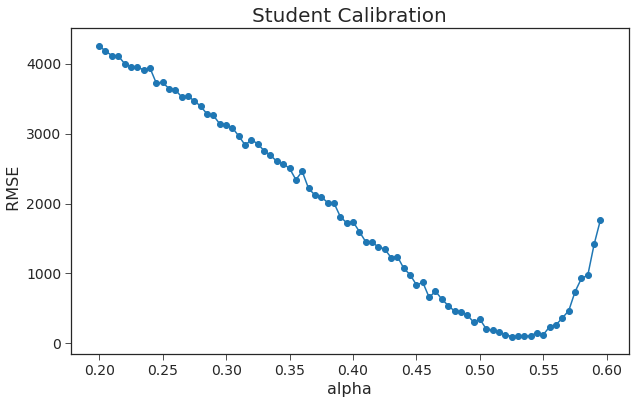

In [8]:
plt.figure(figsize = (10,6))

plt.plot('inputs','RMSE', data=student_cal_results)
plt.scatter('inputs','RMSE', data=student_cal_results)

plt.title('Student Calibration')

plt.xlabel('alpha')
plt.ylabel(' RMSE')

### Simulated vs. Observed Cases

In [10]:
# Loading Data
FS_actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
group_1_cum_cases = pd.read_csv('../../src/simulations_v2/params/jan4calibration/actual_counts_group_1.csv')['cum_case_count']
group_2_cum_cases = pd.read_csv('../../src/simulations_v2/params/jan4calibration/actual_counts_group_2.csv')['cum_case_count']
group_3_cum_cases = pd.read_csv('../../src/simulations_v2/params/jan4calibration/actual_counts_group_3.csv')['cum_case_count']
FS_actual_counts = FS_actuals['cum_case_count']
cornell_count = np.array(group_1_cum_cases) + np.array(group_2_cum_cases) + np.array(group_3_cum_cases) + np.array(FS_actual_counts[:101])
# Cornell_count = np.asarray(pd.read_csv('../res_inst_paper_graphs/Cornell_so_far_updated.csv')['Counts'])

##### All cases

In [11]:
np.random.seed(2021)
random.seed(2021)
calibrated_trajs = get_calibrated_trajs(25)

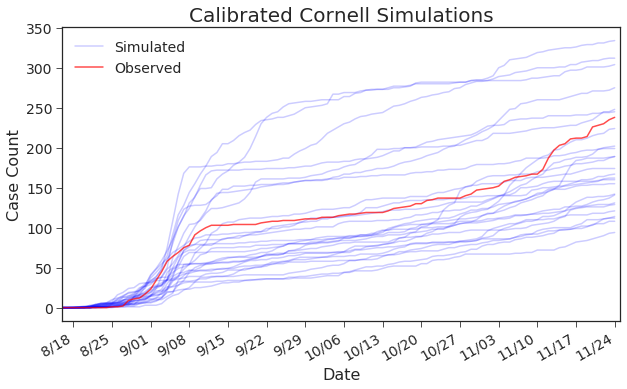

In [16]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))

label = True

for traj in calibrated_trajs:
    cum_traj = get_cum_inf_trajectory(traj[0]) + get_cum_inf_trajectory(traj[1]) + get_cum_inf_trajectory(traj[2]) + get_cum_inf_trajectory(traj[3])
    if label:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2, label='Simulated')
        label = False
    else:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2)

ax.plot(dates_array, cornell_count[:len(dates_array)], alpha=0.7, label='Observed', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,8,16))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Calibrated Cornell Simulations')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

##### Group by Group Simulation figs

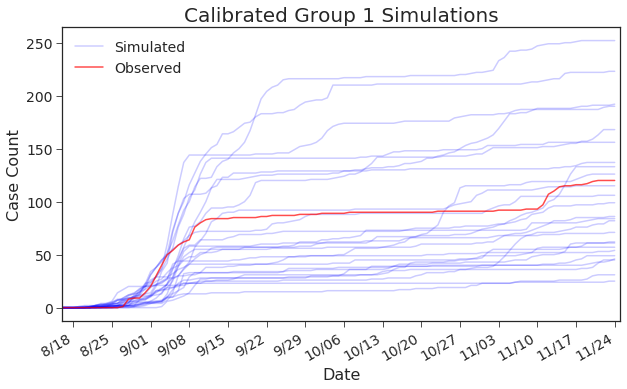

In [17]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))

label = True

for traj in calibrated_trajs:
    cum_traj = get_cum_inf_trajectory(traj[0])
    if label:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2, label='Simulated')
        label = False
    else:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2)

ax.plot(dates_array, group_1_cum_cases[:len(dates_array)], alpha=0.7, label='Observed', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,8,16))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Calibrated Group 1 Simulations')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

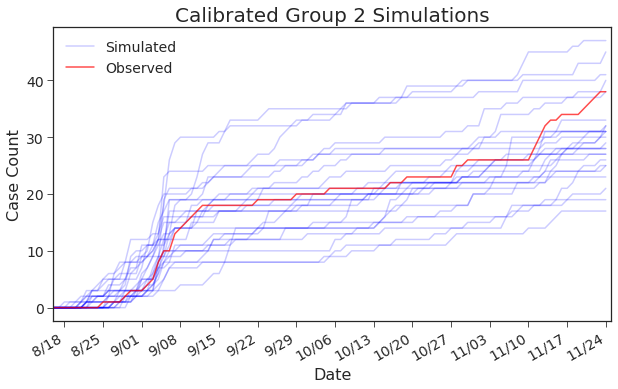

In [18]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))

label = True

for traj in calibrated_trajs:
    cum_traj = get_cum_inf_trajectory(traj[1])
    if label:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2, label='Simulated')
        label = False
    else:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2)

ax.plot(dates_array, group_2_cum_cases[:len(dates_array)], alpha=0.7, label='Observed', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,8,16))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Calibrated Group 2 Simulations')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

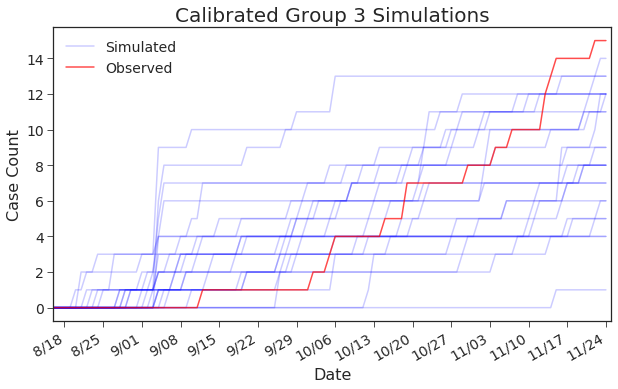

In [19]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))

label = True

for traj in calibrated_trajs:
    cum_traj = get_cum_inf_trajectory(traj[2])
    if label:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2, label='Simulated')
        label = False
    else:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2)

ax.plot(dates_array, group_3_cum_cases[:len(dates_array)], alpha=0.7, label='Observed', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,8,16))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Calibrated Group 3 Simulations')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

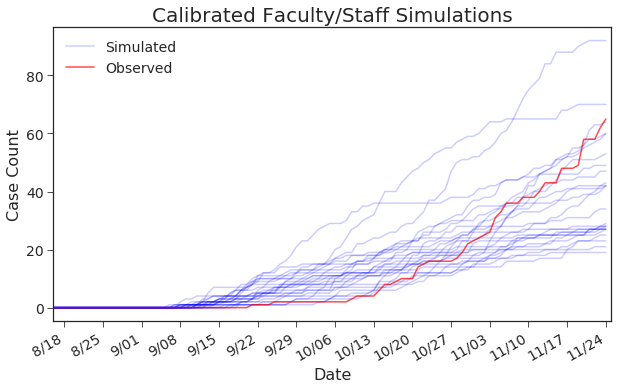

In [20]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))

label = True

for traj in calibrated_trajs:
    cum_traj = get_cum_inf_trajectory(traj[3])
    if label:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2, label='Simulated')
        label = False
    else:
        ax.plot(dates_array, cum_traj[:len(dates_array)], color='blue', alpha=0.2)

ax.plot(dates_array, FS_actual_counts[:len(dates_array)], alpha=0.7, label='Observed', linewidth=1.5, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,8,16))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Calibrated Faculty/Staff Simulations')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

### Trajectories from different scenarios

In [25]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    df_list = list()
    for group in sim.sims:
        df = group.sim_df
        df_list.append(df)
    return df_list

def run_multiple_trajectories(sim, T, n):
    trajs = list()
    for _ in range(n):
        traj = run_multigroup_sim(sim, T)
        trajs.append(traj)
    return trajs

def get_sim_trajs(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)

    group_size = list()
    tests_per_day = 0

    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]

        if 'use_poisson_contact_tracing' in os.environ and os.environ['use_poisson_contact_tracing'] == 'False':
            params['use_poisson_contact_tracing'] = False
        else:
            params['use_poisson_contact_tracing'] = True


        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]

    assert len(group_size) == len(test_frac)

    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    trajs = run_multiple_trajectories(sim, T, n)
    return trajs

In [28]:
def get_cornell_traj(list_dfs):
    traj = get_cum_inf_trajectory(list_dfs[0])
    for df in list_dfs[1:-1]:
        traj += get_cum_inf_trajectory(df)
    return np.array(traj)

In [26]:
np.random.seed(3021)
random.seed(3021)

center_point = get_centre_point()
(center_params_list, center_interaction_matrix, center_group_names), _ = uncertainty_point_to_params_dict(center_point)

lhs_output_sim_files = []
for i in range(2000):
    fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
    lhs_output_sim_files.append(fname)

scenario_data = load_sim_output(lhs_output_sim_files)
res_results = residential_regression(scenario_data)
#res_results = virtual_vs_residential_regression(scenario_data)
res_pessimistic = calculate_pessimistic_scenario(res_results)
(pess_params_list, pess_interaction_matrix, pess_group_names), _ = uncertainty_point_to_params_dict(res_pessimistic)

res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]

center_trajs = get_sim_trajs(center_params_list, center_interaction_matrix, center_group_names, res_test_policy, 112, 50)
pess_trajs = get_sim_trajs(pess_params_list, pess_interaction_matrix, pess_group_names, res_test_policy, 112, 50)

In [51]:
center_list_trajs = list()
pess_list_trajs = list()
for traj in center_trajs:
    center_list_trajs.append(get_cornell_traj(traj))
for traj in pess_trajs:
    pess_list_trajs.append(get_cornell_traj(traj))
center_median_traj = np.median(center_list_trajs, axis=0)
pess_median_traj = np.median(pess_list_trajs, axis=0)

In [41]:
np.random.seed(3022)
random.seed(3022)
calibrated_trajs = get_calibrated_trajs(50)

In [42]:
def get_calibrated_cum_traj(list_dfs):
    traj = get_cum_inf_trajectory(list_dfs[0])
    for df in list_dfs[1:]:
        traj += get_cum_inf_trajectory(df)
    return np.array(traj)

calibrated_list_trajs = list()
for traj in calibrated_trajs:
    calibrated_list_trajs.append(get_calibrated_cum_traj(traj))
calibrated_median_traj = np.median(calibrated_list_trajs, axis=0)

In [47]:
date(2020,8,16)+timedelta(days=17)

datetime.date(2020, 9, 2)

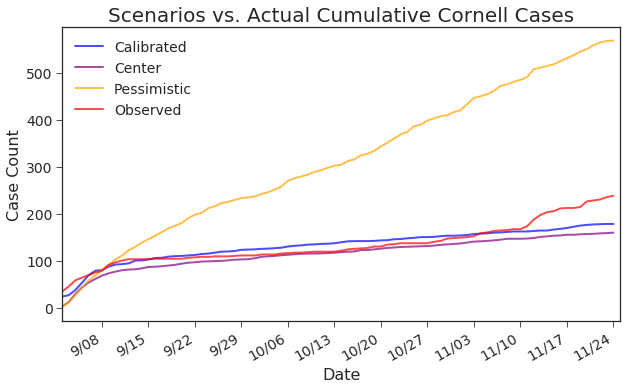

In [56]:
dates_array = mdates.drange(date(2020,8,16), date(2020,8,16)+timedelta(days=101), timedelta(days=1))
dates = mdates.num2date(dates_array)

fig, ax = plt.subplots(figsize=(10,6))


ax.plot(dates_array, calibrated_median_traj[:len(dates_array)], color='blue', alpha=0.7, label='Calibrated', linewidth=2)
ax.plot(dates_array[17:], center_median_traj[:len(dates_array[17:])], color='purple', alpha=0.7, label='Center', linewidth=2)
ax.plot(dates_array[17:], pess_median_traj[:len(dates_array[17:])], color='orange', alpha=0.7, label='Pessimistic', linewidth=2)

ax.plot(dates_array, cornell_count[:len(dates_array)], alpha=0.7, label='Observed', linewidth=2, color='red')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.legend()


formatter = mdates.DateFormatter("%-m/%d")
ax.xaxis.set_major_formatter(formatter)
ax.set_xticks(ax.get_xticks()[::7])

datemin = np.datetime64(date(2020,9,2))
datemax = np.datetime64(date(2020,8,16)+timedelta(days=101))
ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()

plt.title('Scenarios vs. Actual Cumulative Cornell Cases')
plt.xlabel('Date')
plt.ylabel('Case Count')
        
plt.show()

### Testing Pareto

In [4]:
alt_policies = [[1/7,1/7,1/7],
[2/7,1/7,1/7],
[2/7,2/7,1/7],
[2/7,1/7,2/7],
[2/7,2/7,2/7],
[3/7,1/7,1/7],
[3/7,2/7,1/7],
[3/7,3/7,1/7]]

In [5]:
np.random.seed(4021)
random.seed(4021)

alt_test_trajs = list()
for policy in alt_policies:
    alt_test_trajs.append(get_calibrated_trajs(100, test_policy=policy))

In [6]:
file = open('calib_test_pareto.dill', mode='wb')
dill.dump([alt_test_trajs], file)
file.close()

In [11]:
[alt_test_trajs] = dill.load(open('calib_test_pareto.dill', mode='rb'))

In [17]:
group_sizes = [3533, 8438, 6202]

tests_per_day_list = list()
cornell_inf_10 = list()
cornell_inf_50 = list()
cornell_inf_90 = list()

for test_policy, trajs in zip(alt_policies, alt_test_trajs):
    # calculate total tests per day
    tests_per_day = 0
    for group_size, test_freq in zip(group_sizes, test_policy):
        tests_per_day += group_size * test_freq
    cornell_infs = list()
    for traj_dfs in trajs:
        cornell_infs.append(total_infections(traj_dfs) - total_infections([df.head(18) for df in traj_dfs]))
    tests_per_day_list.append(tests_per_day)
    cornell_inf_10.append(np.quantile(cornell_infs, 0.1))
    cornell_inf_50.append(np.quantile(cornell_infs, 0.5))
    cornell_inf_90.append(np.quantile(cornell_infs, 0.9))

calibrated_test_pareto = pd.DataFrame({'tests_per_day': tests_per_day_list, 'cornell_inf_10': cornell_inf_10, 'cornell_inf_50': cornell_inf_50, 'cornell_inf_90': cornell_inf_90})

In [18]:
tests_per_day_list, cornell_inf_10, cornell_inf_50, cornell_inf_90

([2596.142857142857,
  3100.8571428571427,
  4306.285714285714,
  3986.8571428571427,
  5192.285714285714,
  3605.5714285714284,
  4811.0,
  6016.428571428572],
 [177.8,
  140.7,
  116.0,
  133.70000000000002,
  128.70000000000002,
  111.0,
  115.5,
  108.9],
 [546.5, 192.5, 180.5, 203.0, 184.5, 150.5, 151.5, 149.5],
 [1400.9000000000003,
  289.2,
  308.70000000000016,
  281.1,
  285.70000000000016,
  228.0000000000001,
  237.3,
  233.0])

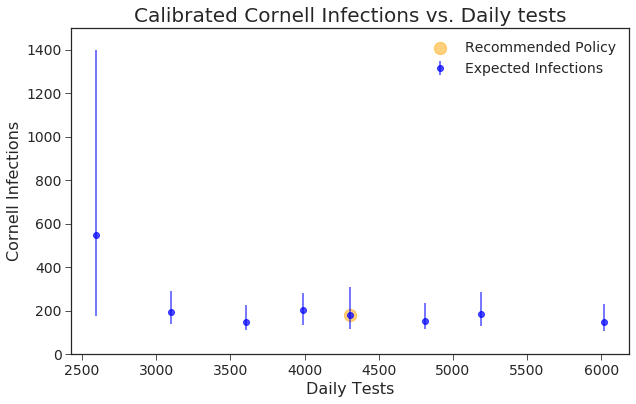

In [14]:
selected_policy_index = 2

f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

plt.subplot(1,1,1)
plt.errorbar(x='tests_per_day', y='cornell_inf_50', yerr = [calibrated_test_pareto['cornell_inf_50'] - calibrated_test_pareto['cornell_inf_10'],calibrated_test_pareto['cornell_inf_90'] - calibrated_test_pareto['cornell_inf_50']], fmt='o', data=calibrated_test_pareto, c='blue', alpha=0.7, label='Expected Infections')
plt.scatter(x=calibrated_test_pareto['tests_per_day'][selected_policy_index], y=calibrated_test_pareto['cornell_inf_50'][selected_policy_index],c='orange',s=150,alpha=0.5, label='Recommended Policy')

# plt.errorbar(x='res_tests_per_day', y='res_cornell_inf_50', yerr = [pess_data['res_cornell_inf_50'] - pess_data['res_cornell_inf_10'], pess_data['res_cornell_inf_90'] - pess_data['res_cornell_inf_50']], fmt='o', data=pess_data, label='Pessimistic', c='red', alpha=0.7)
# plt.scatter(x=pess_data['res_tests_per_day'][selected_policy_index], y=pess_data['res_cornell_inf_50'][selected_policy_index],c='orange',s=150,alpha=0.5)

# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Calibrated Cornell Infections vs. Daily tests')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.ylim([0,1500])

plt.show()

# plt.savefig('res_inst_paper_graphs/mar_19_graphs/testing_policies_pareto.png', dpi=450)

### Virtual Contour Plot

In [19]:
# Initial prevalence groups 1 - 3
student_trajs = sample_student_trajectories(50)

In [26]:
FI_columns = ['E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'pre_ID_0', 'pre_ID_1', 'pre_ID_2', 'pre_ID_3', 'ID_0',
              'ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 'ID_6', 'ID_7', 'SyID_mild_0', 'SyID_mild_1', 'SyID_mild_2',
              'SyID_mild_3', 'SyID_mild_4', 'SyID_mild_5', 'SyID_mild_6', 'SyID_mild_7', 'SyID_mild_8', 'SyID_mild_9',
              'SyID_mild_10', 'SyID_mild_11', 'SyID_mild_12', 'SyID_mild_13', 'SyID_mild_14', 'SyID_mild_15',
              'SyID_mild_16', 'SyID_mild_17', 'SyID_mild_18', 'SyID_mild_19', 'SyID_severe_0', 'SyID_severe_1',
              'SyID_severe_2', 'SyID_severe_3', 'SyID_severe_4', 'SyID_severe_5', 'SyID_severe_6', 'SyID_severe_7',
              'SyID_severe_8', 'SyID_severe_9', 'SyID_severe_10', 'SyID_severe_11', 'SyID_severe_12', 'SyID_severe_13',
              'SyID_severe_14', 'SyID_severe_15', 'SyID_severe_16', 'SyID_severe_17', 'SyID_severe_18', 'SyID_severe_19']

list(student_trajs[0][0][FI_columns].head(18).sum(axis=1))[-1]

23.0

In [29]:
group_1_prev_list = list()
group_2_prev_list = list()
group_3_prev_list = list()

for traj in student_trajs:
    group_1_prev_list.append(list(traj[0][FI_columns].head(18).sum(axis=1))[-1])
    group_2_prev_list.append(list(traj[1][FI_columns].head(18).sum(axis=1))[-1])
    group_3_prev_list.append(list(traj[2][FI_columns].head(18).sum(axis=1))[-1])
    
group_1_initial_prev = np.mean(group_1_prev_list)
group_2_initial_prev = np.mean(group_2_prev_list)
group_3_initial_prev = np.mean(group_3_prev_list)

group_1_initial_prev, group_2_initial_prev, group_3_initial_prev

(21.2, 4.74, 0.78)

In [37]:
def get_test_FNR(sensitivity=0.6, compliance=0.5):
    if 1 - (sensitivity * compliance) > 1:
        print(sensitivity, compliance)
    return 1 - (sensitivity * compliance)

def get_calibrated_virtual_student_params(UG_pop, GS_other_pop, perc_compliant):
    
    g1_comp_params = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_post_movein_private.yaml')[1]
    g1_non_comp_params = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_post_movein_private.yaml')[1]
    g2_comp_params = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_post_movein_private.yaml')[1]
    g2_non_comp_params = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_post_movein_private.yaml')[1]
    g3_params = load_params('../../src/simulations_v2/params/apr7calibration/group_3_students_post_movein_private.yaml')[1]

    g1_popsize = np.ceil(UG_pop * 3533/(3533+8438))
    g2_popsize = UG_pop - g1_popsize
    
    g1_comp_params['exposed_infection_p'] = 0.525
    g1_non_comp_params['exposed_infection_p'] = 0.525
    g2_comp_params['exposed_infection_p'] = 0.525
    g2_non_comp_params['exposed_infection_p'] = 0.525
    g3_params['exposed_infection_p'] = 0.525
    
    g1_comp_params['population_size'] = int(np.ceil(g1_popsize * perc_compliant))
    g1_non_comp_params['population_size'] = g1_popsize - g1_comp_params['population_size']
    g2_comp_params['population_size'] = int(np.ceil(g2_popsize * perc_compliant))
    g2_non_comp_params['population_size'] = g2_popsize - g2_comp_params['population_size']
    g3_params['population_size'] = GS_other_pop + 1594 # 1594 is virtual GS_research population

    g1_comp_params['severe_symptoms_daily_self_report_p'] = 0.36
    g1_non_comp_params['severe_symptoms_daily_self_report_p'] = 0.36
    g2_comp_params['severe_symptoms_daily_self_report_p'] = 0.36
    g2_non_comp_params['severe_symptoms_daily_self_report_p'] = 0.36
    g3_params['severe_symptoms_daily_self_report_p'] = 0.36

    
    g1_comp_params['initial_ID_prevalence'] = group_1_initial_prev / 3533
    g1_non_comp_params['initial_ID_prevalence'] = group_1_initial_prev / 3533
    g2_comp_params['initial_ID_prevalence'] = group_2_initial_prev / 8434
    g2_non_comp_params['initial_ID_prevalence'] = group_2_initial_prev / 8434
    g3_params['initial_ID_prevalence'] = group_3_initial_prev / 6202
    
    g1_non_comp_params['test_protocol_QFNR'] = get_test_FNR()
    g2_non_comp_params['test_protocol_QFNR'] = get_test_FNR()
    
    # NEED TO ADD INITIAL ID PREVALENCE (currently 0)
    
    interaction_matrix = np.array([[92/125 * perc_compliant, 92/125 * (1-perc_compliant), 1/44 * (perc_compliant), 1/44 * (1 - perc_compliant), 0],
                                  [92/125 * perc_compliant, 92/125 * (1-perc_compliant), 1/44 * (perc_compliant), 1/44 * (1 - perc_compliant), 0],
                                  [3.5/125 * perc_compliant, 3.5/125 * (1-perc_compliant), 6.5/44 * perc_compliant, 6.5/44 * (1-perc_compliant), 0],
                                  [3.5/125 * perc_compliant, 3.5/125 * (1-perc_compliant), 6.5/44 * perc_compliant, 6.5/44 * (1-perc_compliant), 0],
                                  [0,0,1/44*perc_compliant,1/44*(1-perc_compliant),1/15]])

    group_names = ['UG (Greek + Athlete) compliant', 'UG (Greek + Athlete) non-compliant', 'UG (other) compliant', 'UG (other) non-compliant', 'GS']
    
    params_list = [g1_comp_params.copy(), g1_non_comp_params.copy(), g2_comp_params.copy(), g2_non_comp_params.copy(), g3_params.copy()]
    return params_list, interaction_matrix, group_names

In [41]:
def get_virtual_infs(UG_pop, GS_other_pop, perc_compliant, ntrajs):
    testing_policy = [2/7,0,2/7,0,1/7]
    
    params_list, interaction_matrix, group_names = get_calibrated_virtual_student_params(UG_pop, GS_other_pop, perc_compliant)
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, ntrajs)
    student_infs = np.array(np.sum(inf_matrix, axis=1))
    
    FS_results = sample_FS_trajectories(ntrajs)
    FS_infs = list()
    for df in FS_results:
        FS_infs.append(get_cum_infections(df))
    FS_infs = np.array(FS_infs)
    
    return student_infs + FS_infs

def run_virtual_sim(UG_pop, GS_other_pop, perc_compliant, filename, ntrajs, random_seed=4021):
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    virtual_infs = get_virtual_infs(UG_pop, GS_other_pop, perc_compliant, ntrajs)
    
    file = open(filename, mode='wb')
    dill.dump([virtual_infs], file)
    file.close()
    
def virtual_sims_process(UG_pop, GS_other_pop, perc_compliant, filename, ntrajs, random_seed):
    p = Process(target = run_virtual_sim, args = (UG_pop, GS_other_pop, perc_compliant, filename, ntrajs, random_seed))
    p.start()
    return p

def launch_virtual_sims(UG_pop_list, GS_other_pop_list, perc_compliant_list, filenames, ntrajs):
    idx = 0
    processes = []
    base_seed = 4021
    
    for UG_pop, GS_other_pop, perc_compliant, filename in zip(UG_pop_list, GS_other_pop_list, perc_compliant_list, filenames):
        idx += 1
        p = virtual_sims_process(UG_pop, GS_other_pop, perc_compliant, filename, ntrajs, random_seed=base_seed+idx)
        processes.append(p)
    
    print("launched {} processes".format(len(processes)))
    for p in processes:
        p.join()
    return processes
    

In [39]:
get_virtual_infs(5000, 5000, 0.5, ntrajs=2)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


[1093.  939.] [60 89]


array([1153., 1028.])

In [70]:
def get_virtual_pops(param):
    virtual_ug_pop = 4500 * (1 - param) + 7950 * param
    virtual_gs_other_pop = 4770 * (1 - param) + 5850 * param
    return virtual_ug_pop, virtual_gs_other_pop

X_popsize = np.linspace(0,1,13)
Y_compliant = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

folder_name = "{}_{}/".format('virtual_calibrated_sims', get_timestamp())
os.mkdir(folder_name)

UG_pop_list = list()
GS_other_pop_list = list()
perc_compliant_list = list()
filenames = list()

for popsize in X_popsize:
    for compliance in Y_compliant:
        virtual_UG, virtual_GS_other = get_virtual_pops(popsize)
        UG_pop_list.append(virtual_UG)
        GS_other_pop_list.append(virtual_GS_other)
        perc_compliant_list.append(compliance)
        filenames.append(folder_name + "{}_{}_{}_{}.dill".format('popsize', popsize, 'compliance', compliance))


launch_virtual_sims(UG_pop_list, GS_other_pop_list, perc_compliant_list, filenames, 100)

launched 143 processes


[<Process(Process-338, stopped)>,
 <Process(Process-339, stopped)>,
 <Process(Process-340, stopped)>,
 <Process(Process-341, stopped)>,
 <Process(Process-342, stopped)>,
 <Process(Process-343, stopped)>,
 <Process(Process-344, stopped)>,
 <Process(Process-345, stopped)>,
 <Process(Process-346, stopped)>,
 <Process(Process-347, stopped)>,
 <Process(Process-348, stopped)>,
 <Process(Process-349, stopped)>,
 <Process(Process-350, stopped)>,
 <Process(Process-351, stopped)>,
 <Process(Process-352, stopped)>,
 <Process(Process-353, stopped)>,
 <Process(Process-354, stopped)>,
 <Process(Process-355, stopped)>,
 <Process(Process-356, stopped)>,
 <Process(Process-357, stopped)>,
 <Process(Process-358, stopped)>,
 <Process(Process-359, stopped)>,
 <Process(Process-360, stopped)>,
 <Process(Process-361, stopped)>,
 <Process(Process-362, stopped)>,
 <Process(Process-363, stopped)>,
 <Process(Process-364, stopped)>,
 <Process(Process-365, stopped)>,
 <Process(Process-366, stopped)>,
 <Process(Proc

In [68]:
# Loading sim results
folder_name = 'virtual_calibrated_sims_1623040591/'
Zs_inf = []

for popsize in X_popsize:
    Z_inf = []
    
    for compliance in Y_compliant:
        fname = folder_name + "{}_{}_{}_{}.dill".format('popsize', popsize, 'compliance', compliance)
        [inf_traj] = dill.load(open(fname, mode='rb'))
#         print(inf_traj)
        Z_inf.append(inf_traj[-1])
    Zs_inf.append(Z_inf)

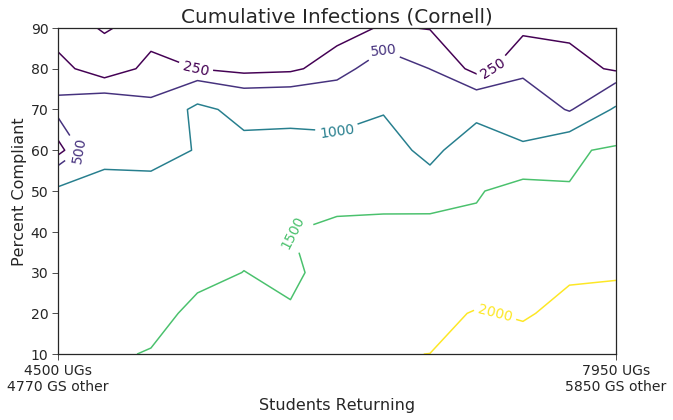

In [69]:
f, axs = plt.subplots(1,1,sharex=True,figsize=(10,6))

inf_levels = [250, 500, 1000, 1500, 2000]
# inf_labels = dict()
# for level in inf_levels:
#     inf_labels[level] = str(level*100) + '%'
    
plt.subplot(1,1,1)
plt.title("Cumulative Infections (Cornell)")
plt.ylabel("Percent Compliant")
plt.xlabel("Students Returning")
# CS = plt.contour(np.array(X_popsize), 100*np.array(Y_compliant), np.array(Zs_inf).T)
CS = plt.contour(np.array(X_popsize), np.array(Y_compliant) * 100, np.array(Zs_inf).T, inf_levels, cmap='viridis')
# plt.clabel(CS, fmt=inf_labels, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fmt='%d', fontsize=14)

plt.xticks([0,1], labels=['4500 UGs\n4770 GS other', '7950 UGs\n5850 GS other'])

plt.show()


# plt.savefig('res_inst_paper_graphs/mar_19_graphs/virtual_test_freq_tr_mult_contour.jpg', dpi=450)

In [ ]:
        
# Zs_hosp = []
# Zs_inf = []
# Zs_UG_hosp = []
# Zs_UG_inf = []

# for popsize in X_popsize:
    
#     Z_hosp = []
#     Z_inf = []
#     Z_UG_hosp = []
#     Z_UG_inf = []
#     for perc_compliant in Y_compliant:
# #for (contacts, popsize), dfs in sensitivity_output.sim_results['Nominal Student Parameters'].items():
#         testing_policy = [2/7,0,2/7,0,1/7]
    
#         params_list, interaction_matrix, group_names = get_calibrated_virtual_params(popsize, perc_compliant)
        
#         virtual_normal = list()
        
#         print('Evaluating this: ', popsize, perc_compliant)
#         tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, testing_policy, 112, 50)

#         virtual_normal.append({'test_policy': testing_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})        
        
#         Z_hosp.append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5))
#         Z_inf.append(np.quantile(np.sum(inf_matrix, axis=1), 0.5))
#         Z_UG_hosp.append(np.quantile(np.sum(np.array(hosp_matrix)[:,:-1],axis=1), 0.5))
#         Z_UG_inf.append(np.quantile(np.sum(np.array(inf_matrix)[:,:-1],axis=1), 0.5))        

#     Zs_hosp.append(Z_hosp)
#     Zs_inf.append(Z_inf)
#     Zs_UG_hosp.append(Z_UG_hosp)
#     Zs_UG_inf.append(Z_UG_inf)

# Student Calibration Code

In [2]:

movein_selfiso_params = load_params('../../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]



g1_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_pre_semester_private.yaml')[1]
g1_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_1_students_post_movein_private.yaml')[1]

g2_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_pre_semester_private.yaml')[1]
g2_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_2_students_post_movein_private.yaml')[1]


g3_base_params_free  = load_params('../../src/simulations_v2/params/apr7calibration/group_3_students_pre_semester_private.yaml')[1]
g3_base_params_post_movein = load_params('../../src/simulations_v2/params/apr7calibration/group_3_students_post_movein_private.yaml')[1]

#Load Actuals

actuals1 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_1.csv')
actuals2 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_2.csv')
actuals3 = pd.read_csv('../../src/simulations_v2/params/apr7calibration/actual_counts_group_3.csv')


actual_counts1 = actuals1['cum_case_count']
actual_counts2 = actuals2['cum_case_count']
actual_counts3 = actuals3['cum_case_count']


g1_movein_contact_matrix = np.matrix([
    [g1_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g2_movein_contact_matrix = np.matrix(
   [ [g2_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g3_movein_contact_matrix = np.matrix(
   [ [g3_base_params_free['expected_contacts_per_day'], 0],
    [0, 0]])

g1_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36
g2_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36
g3_base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:

def sample_movein_trajectory(transmission_p):
    
    movein_time_horizon = 18

    init_pop_count = 485
    avg_init_cases = 5.77
    new_population_counts = [int(count) for count in """103
    224
    101
    93
    90
    70
    117
    442
    462
    125
    281
    77
    206
    100
    228
    89
    106
    134""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g1_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g1_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}



    init_pop_count = 1159
    avg_init_cases = 3.37
    new_population_counts = [int(count) for count in """245
    535
    240
    222
    215
    167
    280
    1055
    1103
    298
    671
    183
    493
    238
    546
    211
    252
    321""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g2_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g2_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}


    init_pop_count = 5171
    avg_init_cases = 0
    new_population_counts = [int(count) for count in """52
    69
    45
    57
    103
    59
    65
    63
    55
    47
    41
    31
    25
    48
    40
    45
    38
    147""".split('\n')]

    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)



    g3_free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        g3_free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
    
    
    
    g1_base_params_free['exposed_infection_p'] = transmission_p
    g1_base_params_post_movein['exposed_infection_p'] = transmission_p
    g2_base_params_free['exposed_infection_p'] = transmission_p
    g2_base_params_post_movein['exposed_infection_p'] = transmission_p
    g3_base_params_free['exposed_infection_p'] = transmission_p
    g3_base_params_post_movein['exposed_infection_p'] = transmission_p
    
    
    g1_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g1_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g2_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g2_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    g3_base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
    g3_base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

    
    dynamic_pop_sim1 = DynamicPopulationSim(
        g1_base_params_free,
        movein_selfiso_params,
        g1_base_params_post_movein,
        g1_movein_contact_matrix,
        movein_time_horizon,
        g1_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim2 = DynamicPopulationSim(
        g2_base_params_free,
        movein_selfiso_params,
        g2_base_params_post_movein,
        g2_movein_contact_matrix,
        movein_time_horizon,
        g2_free_group_population_dynamics,
        {}
    )

    dynamic_pop_sim3 = DynamicPopulationSim(
        g3_base_params_free,
        movein_selfiso_params,
        g3_base_params_post_movein,
        g3_movein_contact_matrix,
        movein_time_horizon,
        g3_free_group_population_dynamics,
        {}
    )
    
    
    contact_matrix = np.matrix([[0.736, 0.023, 0],[.028, .148, 0], [0, 0.023, .067]])
    
    
    multigroup_sim = MultiGroupSimulationDynamicPopulation([dynamic_pop_sim1, dynamic_pop_sim2,dynamic_pop_sim3], contact_matrix)
    for _ in range(0,len(actual_counts1)-1):
        multigroup_sim.step()

    movein_df = dynamic_pop_sim1.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim1.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r1 = list(df['QI'])
    
    movein_df = dynamic_pop_sim2.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim2.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r2 = list(df['QI'])
    
    movein_df = dynamic_pop_sim3.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim3.post_movein_sim.sim_df
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])
    r3 = list(df['QI'])
    
    return [r1,r2,r3]

def sample_trajectories(transmission_p, ntrajectories):
    print(transmission_p)
    g1_trajectories = []
    g2_trajectories = []
    g3_trajectories = []
    for _ in range(ntrajectories):
        t =sample_movein_trajectory(transmission_p)
        g1_trajectories.append(t[0])
        g2_trajectories.append(t[1])
        g3_trajectories.append(t[2])
    return [g1_trajectories,g2_trajectories,g3_trajectories]


def score_trajectories_average(list_of_trajectories):
    g1_trajectories_avg = np.mean(list_of_trajectories[0],axis = 0)
    g2_trajectories_avg = np.mean(list_of_trajectories[1],axis = 0)
    g3_trajectories_avg = np.mean(list_of_trajectories[2],axis = 0)
    
    sum_of_squares = 0
    for i in range(0,len(g1_trajectories_avg)):
        sum_of_squares = sum_of_squares + (g1_trajectories_avg[i]-actual_counts1[i])**2
        sum_of_squares = sum_of_squares + (g2_trajectories_avg[i]-actual_counts2[i])**2
        sum_of_squares = sum_of_squares + (g3_trajectories_avg[i]-actual_counts3[i])**2
    
    return   sum_of_squares/ len(g1_trajectories_avg) 
    


In [4]:
# from analysis_helpers import binomial_exit_function
# from dynamic_population_sim import DynamicPopulationSim
# from multi_group_simulation_dynamic_population import MultiGroupSimulationDynamicPopulation
student_trajectories = sample_trajectories(0.525, 100)

0.525


In [5]:
# Average calibrated student trajectory
g1_avg_trajs = list()
for g1_traj in student_trajectories[0]:
    g1_avg_trajs.append(get_cum_inf_trajectory(g1_traj))
g1_avg_traj = np.mean(g1_avg_trajs, axis=0)

g2_avg_trajs = list()
for g2_traj in student_trajectories[1]:
    g2_avg_trajs.append(get_cum_inf_trajectory(g2_traj))
g2_avg_traj = np.mean(g2_avg_trajs, axis=0)

g3_avg_trajs = list()
for g3_traj in student_trajectories[2]:
    g3_avg_trajs.append(get_cum_inf_trajectory(g3_traj))
g3_avg_traj = np.mean(g3_avg_trajs, axis=0)

TypeError: list indices must be integers or slices, not list

In [7]:
student_trajectories[0][0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 6,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 18,
 22,
 22]

# Faculty / Staff Calibration Code

In [ ]:
base_params_free = load_params('../../src/simulations_v2/params/jan4calibration/faculty_staff_post_movein_private.yaml')[1]
base_params_selfiso = load_params('../../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../../src/simulations_v2/params/jan4calibration/faculty_staff_pre_semester_private.yaml')[1]

base_params_free['severe_symptoms_daily_self_report_p'] = 0.36
base_params_selfiso['severe_symptoms_daily_self_report_p'] = 0.36
base_params_post_movein['severe_symptoms_daily_self_report_p'] = 0.36

In [ ]:
outside_infection_week = pd.DataFrame({'week':list(range(34,53)), 'new_weekly_cases':[0,0,0,0,0.000014,0,0,0.000056,0.000097,0.000014,0.000125,0.000083,0.000125,0.000194,0.000167,0.000320,0.000306,0.000264,0.000320]})


In [ ]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 10283 
base_params_free['test_population_fraction'] = 0 
base_params_free['test_protocol_QFNR'] =.43
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
#base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] =0.098 #weighted average for students, weighted average for faculty and staff
base_params_free['test_protocol_QFNR'] = .43
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 10283
new_population_counts = [int(count) for count in """0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])


def init_movein_sim(transmissions_per_contact, isolations_per_trace=None, outside_infection_week = None):
    avg_init_cases = 0
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['outside_infection_p_array'] = outside_infection_week
    
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
        base_params_post_movein['cases_isolated_per_contact']=isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
        
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [ ]:
FS_actuals = pd.read_csv('https://raw.githubusercontent.com/peter-i-frazier/group-testing/master/src/simulations_v2/params/jan4calibration/actual_counts_group_4_extended_period.csv')
FS_actual_counts = actuals['cum_case_count']
len(FS_actual_counts)

In [ ]:
def sample_FS_movein_trajectory(transmission_p, isos_per_trace=None,outside_infection_week = None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace,outside_infection_week)
    # for each day
    for i in range(len(actual_counts)-1):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return df

def sample_FS_trajectories(transmission_p, ntrajectories, isos_per_trace=None, outside_infection_week = None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_FS_movein_trajectory(transmission_p, isos_per_trace,outside_infection_week)
        trajectories.append(t)
    return trajectories

In [ ]:
staff_trajectories = sample_FS_trajectories(0.011,100,None,outside_infection_week)